Simple Design



---

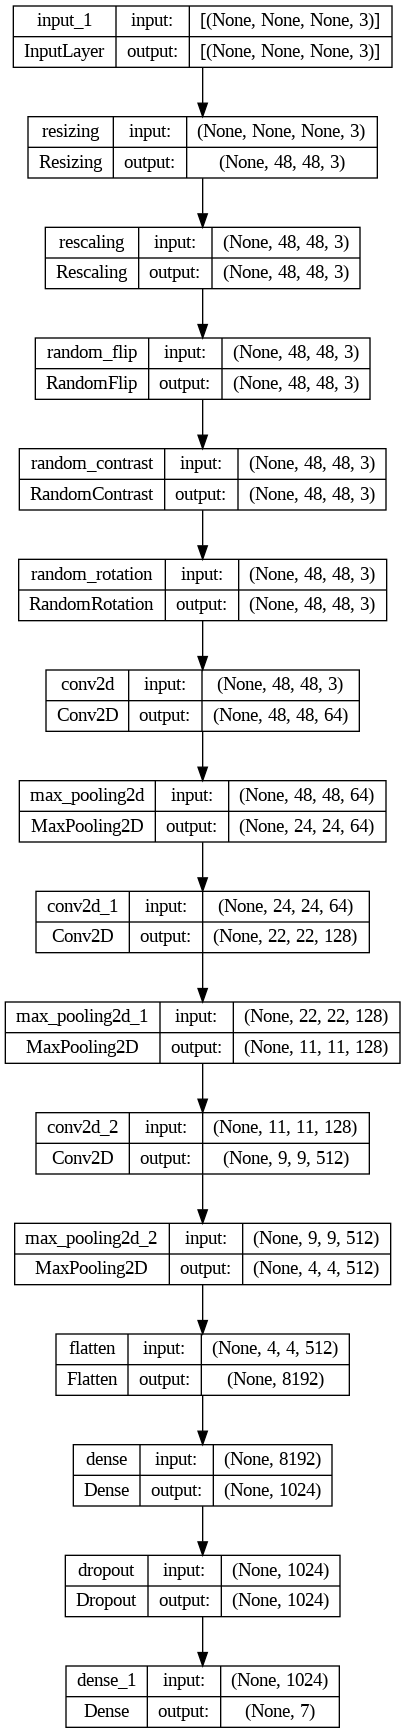
---

- Weighted loss
- Ciclyc Learnig Rate
- Early Stopping



---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hardware Setup

---



In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep  5 21:55:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install --upgrade tensorflow==2.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as K


In [6]:
print(tf.__version__)

2.13.0


# Creating dataset and model and Model Weights

In [7]:
img_train = '/content/drive/MyDrive/Colab Notebooks/ProyFinal/Achive/train'
# img_train = "train"


traindataset = K.utils.image_dataset_from_directory(img_train,
                                                    label_mode='categorical',
                                                    color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=7,
                                                    )

img_test = '/content/drive/MyDrive/Colab Notebooks/ProyFinal/Achive/test'
# img_test = "test"

testdataset = K.utils.image_dataset_from_directory(img_test,
                                                    label_mode='categorical',
                                                    color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=7,
                                                    )


Found 28729 files belonging to 7 classes.
Found 7208 files belonging to 7 classes.


In [8]:
# Images from 1 to 3 channels

def convert_to_rgb(image, label):
    image_rgb = tf.repeat(image, repeats=3, axis=-1)
    return image_rgb, label


traindataset = traindataset.map(convert_to_rgb)
testdataset = testdataset.map(convert_to_rgb)

In [22]:
# Model weights
from sklearn.preprocessing import OneHotEncoder


y_train = pd.read_json('/content/drive/MyDrive/Colab Notebooks/ProyFinal/Achive/categor').values

y_train = y_train.flatten()
print(type(y_train))
print(y_train.shape)

num_classes = len(np.unique(y_train))

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {i: class_weights[i] for i in range(num_classes)}
print(class_weight_dict)

<class 'numpy.ndarray'>
(28729,)
{0: 1.0247547708221865, 1: 9.413171690694627, 2: 1.001743435963597, 3: 0.5688347688347688, 4: 0.8249533381191673, 5: 0.8497190180419995, 6: 1.2942740009911249}


In [26]:
model_path = '/content/drive/MyDrive/Colab Notebooks/ProyFinal/colabs/EmoteAI090W200.h5'

input = K.Input(shape=(None, None, 3))

x = input
x = K.layers.experimental.preprocessing.Resizing(48, 48)(x)
x = K.layers.experimental.preprocessing.Rescaling(1./255)(x)
x = K.layers.experimental.preprocessing.RandomFlip('horizontal', 0)(x)
x = K.layers.experimental.preprocessing.RandomContrast([0.9, 1.1], 1)(x)
x = K.layers.experimental.preprocessing.RandomRotation((-0.2, 0.3), seed=2)(x)

x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(512, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Flatten()(x)

x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
# x = Dense(521, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.5)(x)
# x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.5)(x)
# x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
# x = Dropout(0.5)(x)

output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

model = K.Model(input, output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing_2 (Resizing)       (None, 48, 48, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 48, 48, 3)         0         
                                                                 
 random_contrast_2 (RandomC  (None, 48, 48, 3)         0         
 ontrast)                                                        
                                                                 
 random_rotation_2 (RandomR  (None, 48, 48, 3)         0         
 otation)                                                  

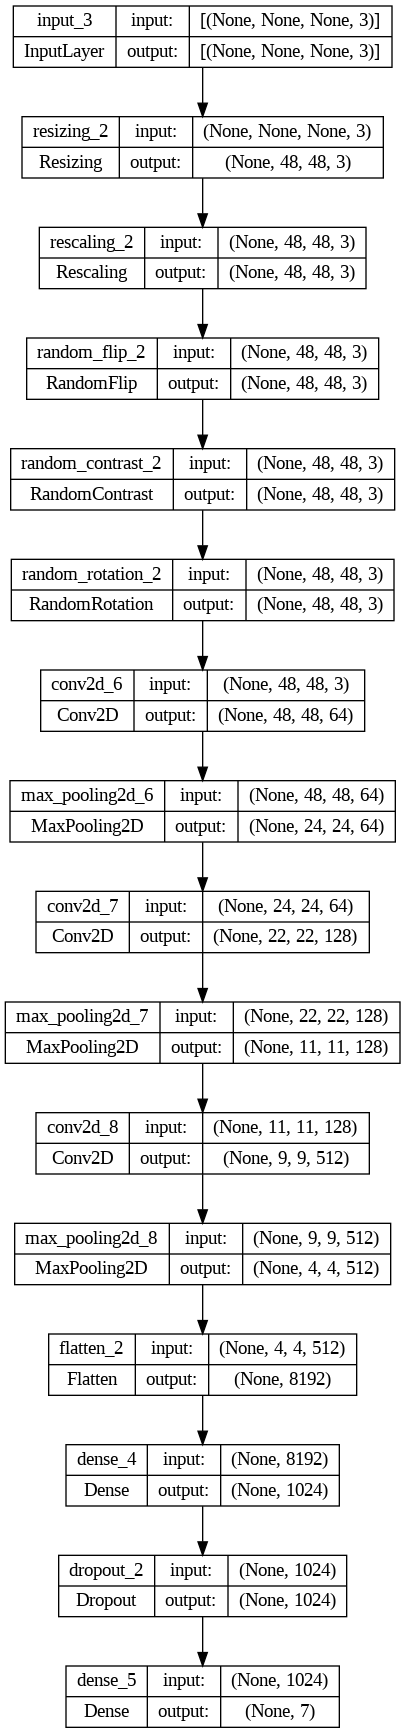

In [27]:
K.utils.plot_model(model,  show_shapes=True, to_file="/content/drive/MyDrive/Colab Notebooks/ProyFinal/colabs/EmoteAI0901Focal200W.png")

In [28]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def cyclic_lr(epoch):
    base_lr = 0.00008
    max_lr = 0.0001
    step_size = 32.0
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x)) / float(2 ** (cycle - 1))
    return lr

best = [K.callbacks.ModelCheckpoint(model_path,
                                   save_best_only=True),
       K.callbacks.LearningRateScheduler(cyclic_lr),
       K.callbacks.EarlyStopping(monitor='val_loss',
                                patience=10,
                                verbose=1)
       ]

history = model.fit(traindataset,
                    validation_data=testdataset,
                    epochs=200,
                    verbose=True,
                    callbacks=best,
                    class_weight=class_weight_dict,
                    use_multiprocessing=True)

Epoch 1/200
898/898 [==============================] - 17s 17ms/step - loss: 1.9384 - accuracy: 0.1390 - val_loss: 1.8864 - val_accuracy: 0.2479 - lr: 8.0000e-05
Epoch 2/200
898/898 [==============================] - 17s 19ms/step - loss: 1.9119 - accuracy: 0.1869 - val_loss: 1.8855 - val_accuracy: 0.2248 - lr: 8.0625e-05
Epoch 3/200
898/898 [==============================] - 17s 19ms/step - loss: 1.8943 - accuracy: 0.1999 - val_loss: 1.8708 - val_accuracy: 0.2304 - lr: 8.1250e-05
Epoch 4/200
898/898 [==============================] - 17s 19ms/step - loss: 1.8628 - accuracy: 0.2167 - val_loss: 1.8184 - val_accuracy: 0.2855 - lr: 8.1875e-05
Epoch 5/200
898/898 [==============================] - 17s 19ms/step - loss: 1.8177 - accuracy: 0.2595 - val_loss: 1.7390 - val_accuracy: 0.3381 - lr: 8.2500e-05
Epoch 6/200
898/898 [==============================] - 17s 19ms/step - loss: 1.7815 - accuracy: 0.2893 - val_loss: 1.6984 - val_accuracy: 0.3578 - lr: 8.3125e-05
Epoch 7/200
898/898 [=======

In [29]:
print(type(history.history))
print(history.history.keys())
largo = len(history.history['accuracy'])
largo

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


91

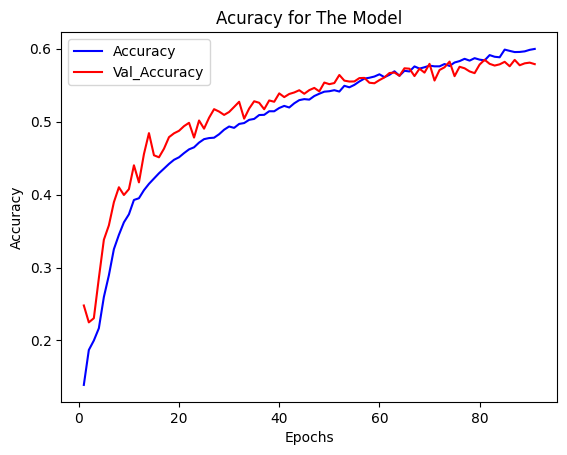

In [30]:
# Review Accuracy

plt.plot(range(1, largo + 1), history.history['accuracy'], '-b', label='Accuracy')
plt.plot(range(1, largo + 1), history.history['val_accuracy'], '-r', label='Val_Accuracy')
plt.title('Acuracy for The Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
eval = model.evaluate(testdataset, verbose=True, use_multiprocessing=True, return_dict=True)

226/226 [==============================] - 3s 13ms/step - loss: 1.1365 - accuracy: 0.5789


In [32]:
print(eval)

{'loss': 1.1365196704864502, 'accuracy': 0.5789400935173035}


In [33]:
prediction = model.predict(testdataset)

226/226 [==============================] - 3s 12ms/step


In [34]:
print(prediction)
print(prediction.shape)

[[5.8783722e-01 5.5898629e-02 2.1640921e-02 ... 3.8800303e-02
  2.5827248e-02 4.5356667e-04]
 [6.4851157e-03 9.8673511e-01 2.0409438e-03 ... 6.2799786e-04
  3.8197052e-03 2.0054384e-07]
 [4.6958289e-01 1.3156000e-02 1.8933009e-01 ... 8.5119255e-02
  2.3699529e-01 5.8159367e-03]
 ...
 [1.8080804e-02 6.4009073e-06 5.2440460e-03 ... 4.5657214e-03
  7.5104423e-03 2.0583409e-03]
 [7.8351252e-02 5.2396562e-03 4.5651370e-01 ... 1.3162161e-01
  1.8961582e-01 1.3645735e-01]
 [1.0934716e-01 9.5985522e-03 1.1388470e-01 ... 4.2779011e-01
  2.9936340e-01 3.1165306e-03]]
(7208, 7)


In [35]:
y_true = []
y_pred = []

for x, y in testdataset:
    predictions = model.predict(x)

    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = np.argmax(y.numpy(), axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)


1/1 [==============================] - 0s 85ms/step


In [36]:
!pip install scikit-learn
!pip install seaborn

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

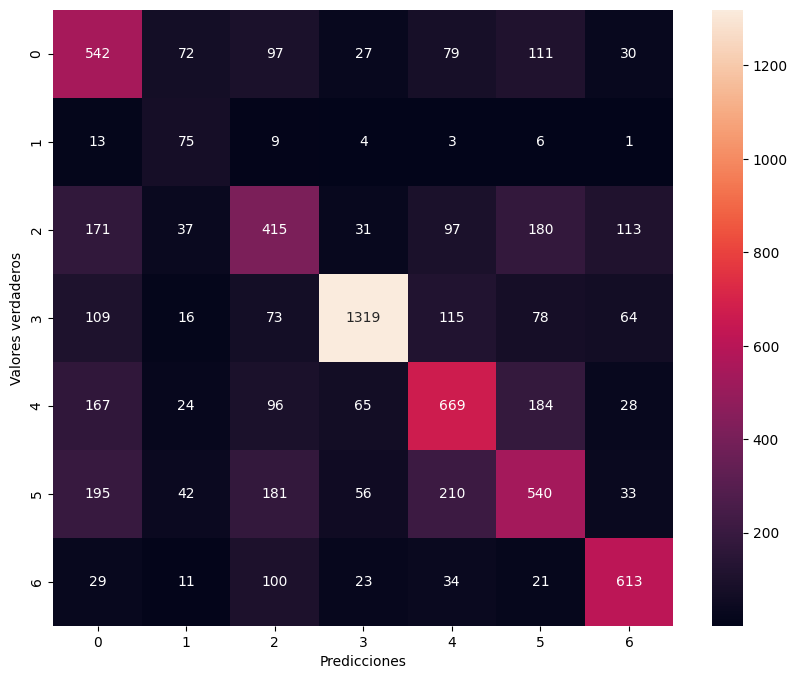

In [38]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.show()
